# Task 1 - Solubility Predictions

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import Draw
import scipy

# compare pca number of components with logistic regression algorithm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot

# sklearn 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

#from sklearn import metrics
from sklearn.metrics import mean_absolute_error, r2_score 
from sklearn.inspection import permutation_importance

In [2]:
# Load in the data and visualise
df = pd.read_csv('Husskonen_Solubility_Features.csv')
df

,0,Compound_Identifier,Source,SMILES,LogS.M.,MW,AMW,Sv,Se,Sp,...,Psychotic-80,Psychotic-50,Hypertens-80,Hypertens-50,Hypnotic-80,Hypnotic-50,Neoplastic-80,Neoplastic-50,Infective-80,Infective-50\r\r\n
0,1,HU_100,Huuskonen,c1ccc2ccc3nccnc3c2c1,-2.68,180.22,8.192,15.623,21.854,16.296,...,0,0,0,0,1,0,1,0,1,0
1,2,HU_1000,Huuskonen,c1cnc2c(C)ncnc2n1,-0.12,146.17,8.598,11.612,17.291,11.784,...,0,0,0,0,0,0,0,0,0,0
2,3,HU_1001,Huuskonen,c1cnc2cnc(C)nc2n1,-0.47,146.17,8.598,11.612,17.291,11.784,...,0,0,0,0,0,0,0,0,0,0
3,4,HU_1002,Huuskonen,c1c(C)nc2cncnc2n1,0.06,146.17,8.598,11.612,17.291,11.784,...,0,0,0,0,0,0,0,0,0,0
4,5,HU_1003,Huuskonen,c1cnc2c(OC)ncnc2n1,-1.11,162.17,9.009,12.327,18.618,12.239,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
927,928,HU_T2_5,Huuskonen,c1ccccc1N2C(=O)C=C(C)N2C,-0.56,188.25,7.240,16.392,25.949,17.273,...,0,0,0,0,1,0,1,0,1,0
928,929,HU_T2_6,Huuskonen,n(c(nc(n1)NC(C)C)NCC)c1Cl,-3.85,215.72,7.704,16.569,28.251,17.693,...,0,0,1,0,1,0,1,0,1,0
929,930,HU_T2_7,Huuskonen,CCC1(C(=O)NC(=O)NC1=O)c2ccccc2,-2.34,232.26,8.009,18.821,29.604,19.182,...,0,0,1,0,1,1,1,0,1,0
930,931,HU_T2_8,Huuskonen,O=C(N(C)C)Nc(ccc(c1Cl)Cl)c1,-3.80,233.11,9.713,16.047,24.596,16.989,...,0,0,0,0,1,0,1,0,1,0


In [3]:
# Remove any columns that have strings or NaN
lst = []

# Loops through all the columns
for i in df:
    for value in df[i]:
        if type(value) == str:
            lst.append(str(i))

            
# Remove unwanted columns for now
remove = list(set(lst))
df = df.drop(columns=remove)

# Remove index artifact column
df = df.drop(columns=['0'])

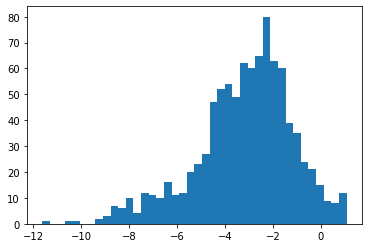

In [4]:
plt.hist(df['LogS.M.'], bins=40)
plt.show()

## Functions

In [ ]:
remove_collin(df)

In [7]:
print('Before: ', len(df.columns))
df.dropna(inplace=True)
print('After: ', len(df.columns))

Before:  2257
After:  2257


In [8]:
# split into X and y data
X = df.drop(['LogS.M.'], axis = 1)
y = df['LogS.M.']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 1)

In [11]:
# Define scaler object
sc = StandardScaler()

# Fit and transform the training data independantly of test set to prevent information leakage
s_train = sc.fit_transform(X_train)
s_train = pd.DataFrame(s_train, columns = X_train.columns, index = X_train.index)

# Perform same transformation to the test set
s_test = sc.transform(X_test)
s_test = pd.DataFrame(s_test, columns = X_test.columns, index = X_test.index)

X_train, X_test = s_train, s_test

# Ridge Regression

In [15]:
model = Ridge()

In [16]:
%%time
%%capture 
hyparam = {'alpha': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}
ridge_grid = GridSearchCV(model, hyparam, cv=5, scoring='neg_mean_absolute_error')
ridge_grid.fit(X_train, y_train)

CPU times: user 10.7 s, sys: 405 ms, total: 11.2 s
Wall time: 3.12 s


In [17]:
print(ridge_grid.best_params_)

{'alpha': 100}


In [18]:
# Use the tuned hyperparameters
ridge_model = Ridge(alpha=100)
fit_model = ridge_model.fit(X_train, y_train)
y_pred = fit_model.predict(X_test)

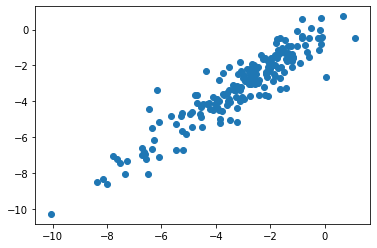

In [19]:
plt.scatter(y_pred, y_test)

In [21]:
mae = round(mean_absolute_error(y_pred, y_test),3)
print('Mean Absolute Error: ', mae)

Mean Absolute Error:  0.565


In [22]:
rel_error = abs((y_test - y_pred.ravel())/y_test)
MedRE = np.median(rel_error)
print(MedRE)

0.1574117634772242


# SVR 

In [25]:
model = SVR(kernel='rbf')

In [26]:
%%time
%%capture
hyparam = {'gamma':['scale', 'auto'], 'epsilon':[0.001, 0.01, 0.025, 0.05, 0.1, 0.25, 0.5, 1], 'C':[0.1, 0.25, 0.5, 1, 2, 5, 10, 20, 30, 50]}
svr_grid = GridSearchCV(model, hyparam, cv=5, scoring='neg_mean_absolute_error')
svr_grid.fit(X_train, y_train)

CPU times: user 6min 7s, sys: 3.88 s, total: 6min 11s
Wall time: 6min 12s


In [27]:
print(svr_grid.best_params_)

{'C': 10, 'epsilon': 0.025, 'gamma': 'auto'}


In [28]:
# Use the tuned hyperparameters
svr_model = SVR(kernel='rbf', C=10, gamma='auto', epsilon=0.025)
fit_model = svr_model.fit(X_train, y_train)
y_pred = fit_model.predict(X_test)

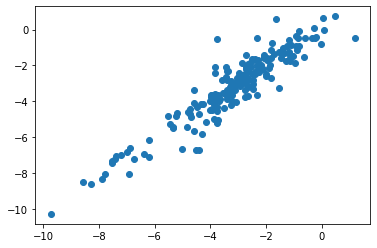

In [29]:
plt.scatter(y_pred, y_test)

In [30]:
mae = round(mean_absolute_error(y_pred, y_test),3)
print('Mean Absolute Error: ', mae)

Mean Absolute Error:  0.515


In [31]:
rel_error = abs((y_test - y_pred.ravel())/y_test)
MedRE = np.median(rel_error)
print(MedRE)

0.13660564768935768
